In [1]:
from IPython.display import display, HTML
display(HTML ("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

- red wine 품질 등급 예측
```
1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler)
    -> 타겟변수원핫인코딩(get_dummies) -> 훈련셋과 테스트셋분리(train_test_split)
2. 모델 구성(입력11, 출력?)
3. 모델학습과정 설정(다중분류로 설정)
4. 모델 학습(callbacks 이용)
5. 모델 평가 - 그래프, 평가(테스셋), 교차표/혼동행렬
6. 모델 저장/사용
```

In [2]:
import numpy as np
import pandas as pd # read_csv, get_dummies, crosstab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
import matplotlib.pyplot as plt

# 1.데이터셋 확보 & 전처리 
- 독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler) -> 타겟변수원핫인코딩(get_dummies) -> 훈련셋과 테스트셋분리(train_test_split)

In [3]:
# 데이터 읽어오기
#np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
#np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)
redwine = pd.read_csv('./data/winequality-red.csv', sep=';')
# 고정 산도(fixed acidity)
# 휘발성 산도(volatile acidity)
# 구연산(citric acid)
# 잔여 당분(residual sugar)
# 염화물(chlorides)
# 유리 아황산염(free sulfur dioxide)
# 총 아황산염(total sulfur dioxide)
# 밀도(density)
# pH
# 황산염(sulphates)
# 알코올(alcohol)
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
# 타겟변수의 균형
redwine['quality'].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [5]:
# 독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_redwine = redwine.iloc[:, -1]
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [8]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaler.fit(X_redwine)
scaled_X_redwine = scaler.transform(X_redwine)
# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()

In [9]:
print('원데이터\t원핫인코딩')
# 원핫인코딩한 0번째 인덱스가 3등급(get_dummies()사용)
np.column_stack([y_redwine[3:5], Y_redwine[3:5]])

원데이터	원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [11]:
# 독립변수: scaled_X_redwine & 타겟변수: Y_redwine
scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [12]:
# 훈련셋과 테스트셋 분리(층화추출)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                   Y_redwine,
                                                   #test_size=0.3,
                                                   train_size=0.7,
                                                   stratify=Y_redwine, #층화추출
                                                   random_state=12)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [14]:
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 2. 모델 구성(입력11, 출력6)

In [15]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, 'relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                600       
                                                                 
 dense_1 (Dense)             (None, 128)               6528      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 30)                3870      
                                                                 
 dense_3 (Dense)             (None, 6)                 186       
                                                                 
Total params: 11,184
Trainable params: 11,184
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습과정 설정(다중분류에 맞는 설정)
# 4. 학습시키기(callbacks 이용)

In [31]:
%%time
model.compile(loss='categorical_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): #on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f},val_acc:{:.4f}'\
                 .format(self.epoch,
                        logs.get('loss'),
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                        )
                 )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    mointor = 'val_accuracy', # 모니터링 지표: loss, val_loss, accuracy
                    save_best_only = True, # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
#학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로
                verbose = 0, #로그출력 막음(콜백함수에서 출력)
                callbacks = [earlyStopping,
                            customHistory,
                            checkpoint])

1번째 loss:0.4465, acc:0.8201, val_loss:1.3215,val_acc:0.5491
5번째 loss:0.4309, acc:0.8369, val_loss:1.2737,val_acc:0.5670
10번째 loss:0.4133, acc:0.8335, val_loss:1.3268,val_acc:0.5670
15번째 loss:0.4186, acc:0.8346, val_loss:1.3205,val_acc:0.5580
20번째 loss:0.3814, acc:0.8525, val_loss:1.3450,val_acc:0.5536
CPU times: total: 1.48 s
Wall time: 1.15 s


In [20]:
X_train.shape

(1119, 11)

# 5. 모델 평가
- 학습과정 시각화, 평가(테스트셋), 교차표(혼동행렬)

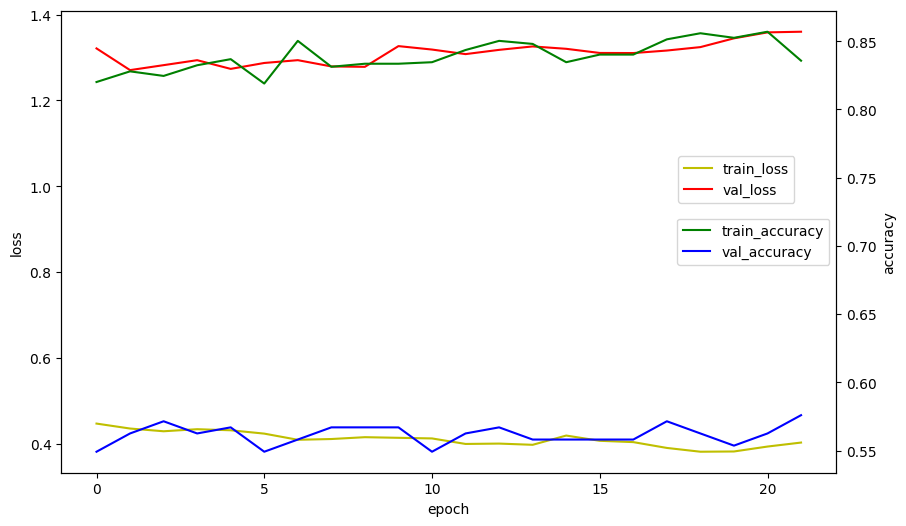

In [32]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [34]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:1.1983, accuracy:0.6104


In [35]:
model1 = load_model('model/wine-022-loss1.3604-acc0.5759.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:1.1983, accuracy:0.6104


In [36]:
model.save('model/wine.h5')

In [37]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1) + 3 # 실제값
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1) + 3
#pred = np.argmax(model.predict(X_test), axis=1)

pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 919us/step


predict,3,4,5,6,7
real,,,,,
3,0,0,2,1,0
4,1,1,8,5,1
5,0,1,136,62,5
6,0,1,46,128,17
7,0,1,3,28,28
8,0,0,0,2,3


# 6. 모델 사용

In [38]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [43]:
input_data = [7.4, 0.7, 0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 16ms/step


array([2], dtype=int64)